In [1]:
import pandas as pd
import re
from textblob import TextBlob
from textstat.textstat import textstat
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
% matplotlib inline

In [2]:
data_1500_kf = pd.read_csv("full_data/english_books_final_deduped_2_to_1500.csv", usecols=["age_in_2017", "genre", "is_non_adult", "proper_title", "extracted_libcount"])

In [3]:
data_1500_kf.head()

,extracted_libcount,age_in_2017,genre,is_non_adult,proper_title
0,1488,15.0,Fiction,1.0,Bloody Jack: Being an Account of the Curious A...
1,1445,12.0,Fiction,0.0,Immortal in Death
2,1425,18.0,Unknown,0.0,The Body's Perilous Pleasures: Dangerous Desir...
3,1424,4.0,Unknown,0.0,The (Honest) Truth About Dishonesty: How We Li...
4,1422,1.0,Fiction,1.0,The Berenstain Bears Meet Santa Bear


In [4]:
data_1500_kf.shape

(3839, 5)

### add the title-based features to the 2-1500 set

In [5]:
data_1500_kf.isnull().sum()

extracted_libcount    0
age_in_2017           8
genre                 0
is_non_adult          0
proper_title          0
dtype: int64

In [6]:
data_1500_kf.dropna(inplace=True)

In [7]:
data_1500_kf.index = range(len(data_1500_kf))

In [8]:
data_1500_kf.shape

(3831, 5)

In [9]:
#add sentiment analysis
def text_blob_sentiment_polarity(value):
    blob = TextBlob(value)
    return blob.sentiment.polarity
def text_blob_sentiment_subjectivity(value):
    blob = TextBlob(value)
    return blob.sentiment.subjectivity

In [10]:
data_1500_kf["sentiment_polarity"] = data_1500_kf["proper_title"].apply(text_blob_sentiment_polarity)


In [11]:
data_1500_kf["sentiment_subjectivity"] = data_1500_kf["proper_title"].apply(text_blob_sentiment_subjectivity)


In [12]:
#add reading level
def reading_level_comp(string):
    try:
        level = textstat.text_standard(string)
        return level
    except:
        return "Unclear"

In [13]:
data_1500_kf["reading_level"] = data_1500_kf["proper_title"].apply(reading_level_comp)

In [14]:
#make reading level into a dummies df
lb_rl = LabelBinarizer()
reading_level_lb = lb_rl.fit_transform(data_1500_kf["reading_level"])

In [15]:
reading_level_dummies = pd.DataFrame(reading_level_lb)

In [16]:
reading_level_dummies.shape

(3831, 49)

In [17]:
#add number of words column
data_1500_kf["number_of_words"] = data_1500_kf["proper_title"].apply(lambda x: len(x.split()))

In [18]:
#add title length
data_1500_kf["title_length"] = data_1500_kf["proper_title"].apply(lambda x: len(x))

In [19]:
#this is not a title feature but may use
def fiction_binarizer(value):
    if "Fiction" in value:
        return 1
    elif "Poetry" in value:
        return 1
    elif "Drama" in value:
        return 1
    else:
        return 0

In [20]:
data_1500_kf["is_fiction"] = data_1500_kf["genre"].apply(fiction_binarizer)

In [21]:
#add topic modeling
cv_for_lda = CountVectorizer(min_df=5, max_df=.75, ngram_range=(1,3), stop_words="english")

words = cv_for_lda.fit_transform(data_1500_kf["proper_title"])

In [22]:
lda_8 = LatentDirichletAllocation(n_topics=8, max_iter=15,
                                topic_word_prior=2,
                                learning_offset=50., random_state=3)

lda_8.fit(words)

/Users/annafriedman/anaconda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=50.0, max_doc_update_iter=100, max_iter=15,
             mean_change_tol=0.001, n_jobs=1, n_topics=8, perp_tol=0.1,
             random_state=3, topic_word_prior=2, total_samples=1000000.0,
             verbose=0)

In [23]:
transformed_data_8= lda_8.transform(words)
transformed_data_8 = pd.DataFrame(transformed_data_8, columns=['Topic %s' % x for x in range(8)])

In [24]:
def top_topic_number_extractor(dataframe):
    top_topic_list = []
    for i in dataframe.index:
        ordered_row = dataframe.iloc[i,:].sort_values(ascending=False)
        top_topic_name = ordered_row.index[0]
        count_pattern = re.compile("\d+")
        top_topic_number = count_pattern.search(top_topic_name).group()
        top_topic_list.append(int(top_topic_number))
    return top_topic_list

In [25]:
data_1500_kf["top_topic_number_lda8"] = top_topic_number_extractor(transformed_data_8)

In [26]:
#make dummy variable columns for top topic number
lb = LabelBinarizer()
topic_lb = lb.fit_transform(data_1500_kf["top_topic_number_lda8"])

In [27]:
#make df with categoricalized top topics
top_topics_df = pd.DataFrame(topic_lb)
top_topics_df.head()

,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0


In [28]:
#tfidf vectorize the words:
#all lowercase consistently worked worse, so keeping capitalization here
#giving this a test now with stopwords--still unclear if they should stay
tfidf = TfidfVectorizer(min_df=5, max_df=.95, lowercase=False, stop_words="english", ngram_range=(1,3))
tfidf_title = tfidf.fit_transform(data_1500_kf["proper_title"])

In [29]:
len(tfidf.vocabulary_)

923

In [30]:
#make it into a df to join onto beginning data:
tfidf_title_df = pd.DataFrame(tfidf_title.todense(), 
                  columns=tfidf.get_feature_names())

In [31]:
tfidf_title_df.shape

(3831, 923)

In [32]:
data_1500_kf.head()

,extracted_libcount,age_in_2017,genre,is_non_adult,proper_title,sentiment_polarity,sentiment_subjectivity,reading_level,number_of_words,title_length,is_fiction,top_topic_number_lda8
0,1488,15.0,Fiction,1.0,Bloody Jack: Being an Account of the Curious A...,-0.450000,0.950000,11th and 12th grade,15,89,1,6
1,1445,12.0,Fiction,0.0,Immortal in Death,0.000000,0.000000,3th and 4th grade,3,17,1,0
2,1425,18.0,Unknown,0.0,The Body's Perilous Pleasures: Dangerous Desir...,-0.216667,0.533333,36th and 37th grade,9,73,0,0
3,1424,4.0,Unknown,0.0,The (Honest) Truth About Dishonesty: How We Li...,0.600000,0.900000,24th and 25th grade,11,81,0,5
4,1422,1.0,Fiction,1.0,The Berenstain Bears Meet Santa Bear,0.000000,0.000000,1th and 2th grade,6,36,1,3


In [33]:
data_1500_kf.shape

(3831, 12)

### create y and X for modeling

In [34]:
y = data_1500_kf["extracted_libcount"]

In [35]:
X = pd.concat([data_1500_kf[["age_in_2017", "is_non_adult", "sentiment_polarity", "sentiment_subjectivity", "number_of_words", "title_length", "is_fiction"]], top_topics_df, tfidf_title_df, reading_level_dummies], axis=1)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

In [37]:
rfr = RandomForestRegressor(min_samples_leaf=5, n_estimators=20)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [38]:
rfr.score(X_train, y_train)

0.43341825291584152

In [39]:
rfr.score(X_test, y_test)

0.033171711507772983

In [40]:
predicted_vals = rfr.predict(X_test)

In [41]:
explained_variance_score(predicted_vals, y_test)

-5.917131873779633

In [42]:
mean_absolute_error(predicted_vals, y_test)

167.55089389510965

In [43]:
mean_squared_error(predicted_vals, y_test)

59807.559784906363

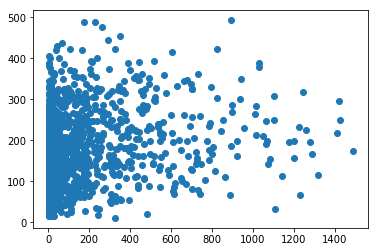

In [44]:
plt.scatter(y_test, predicted_vals)

### try with different features

In [36]:
#just age and title stuff:
X2 = pd.concat([data_1500_kf[["age_in_2017", "sentiment_polarity", "sentiment_subjectivity", "number_of_words", "title_length"]], top_topics_df, tfidf_title_df, reading_level_dummies], axis=1)


In [37]:
X2.shape

(3831, 985)

In [38]:
X2.head()

,age_in_2017,sentiment_polarity,sentiment_subjectivity,number_of_words,title_length,0,1,2,3,4,...,39,40,41,42,43,44,45,46,47,48
0,15.0,-0.450000,0.950000,15,89,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12.0,0.000000,0.000000,3,17,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18.0,-0.216667,0.533333,9,73,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,0.600000,0.900000,11,81,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.000000,0.000000,6,36,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
X2_train, X2_test = train_test_split(X2, test_size=0.33, random_state=3)

In [49]:
rfr_2 = RandomForestRegressor(min_samples_leaf=5, n_estimators=20)
rfr_2.fit(X2_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [50]:
rfr_2.score(X2_train, y_train)

0.41539345279825607

In [51]:
rfr_2.score(X2_test, y_test)

0.040969138784417769

In [52]:
predicted_vals_2 = rfr_2.predict(X2_test)

In [53]:
explained_variance_score(predicted_vals_2, y_test)

-6.2283099356445693

In [54]:
mean_absolute_error(predicted_vals_2, y_test)

166.36386709864033

In [55]:
mean_squared_error(predicted_vals_2, y_test)

59325.214467162645

(0, 1400)

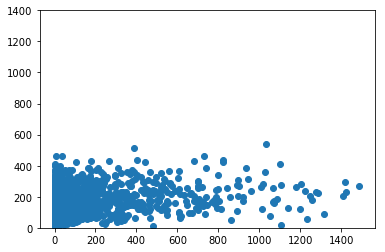

In [56]:
plt.scatter(y_test, predicted_vals_2)
plt.ylim(0,1400)

### try without age

In [57]:
#just title stuff:
X3 = pd.concat([data_1500_kf[["sentiment_polarity", "sentiment_subjectivity", "number_of_words", "title_length"]], top_topics_df, tfidf_title_df, reading_level_dummies], axis=1)


In [58]:
X3_train, X3_test = train_test_split(X3, test_size=0.33, random_state=3)

In [59]:
rfr_3 = RandomForestRegressor(min_samples_leaf=5, n_estimators=20)
rfr_3.fit(X3_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [60]:
rfr_3.score(X3_train, y_train)

0.36006600172449776

In [61]:
rfr_3.score(X3_test, y_test)

0.0058761294419953369

In [62]:
# ### GridSearch on data set 1
# parameters = {"n_estimators": [10, 20, 50, 100, 200], "max_features": [.30, .50, .70, .90], "max_depth": [5, 10, 15, 20], "min_samples_leaf": [2, 3, 4, 5, 7, 10]}
# rf = RandomForestRegressor()
# grid = GridSearchCV(rf, parameters)

In [63]:
#commenting this out for now, since it takes so long to run
# grid.fit(X_train, y_train)

In [64]:
#best score was: 0.054772596880442219
# grid.best_score_

In [65]:
#best params were: 
# {'max_depth': 15,
#  'max_features': 0.3,
#  'min_samples_leaf': 10,
#  'n_estimators': 100}
#see below for model run with best params
# grid.best_params_

In [66]:
# rfr_best_params = RandomForestRegressor(max_depth=15, max_features=0.3, min_samples_leaf=10, n_estimators=100)
# rfr_best_params.fit(X_train, y_train)

In [67]:
# rfr_best_params.score(X_train, y_train)

In [68]:
# rfr_best_params.score(X_test, y_test)

In [69]:
# rfr_bp_predictions = rfr_best_params.predict(X_test)

In [70]:
# mean_absolute_error(y_test, rfr_bp_predictions)

In [71]:
# plt.scatter(y_test, rfr_bp_predictions)

In [72]:
### GridSearch on data set 2
parameters = {"n_estimators": [10, 20, 50, 100, 200], "max_features": [.10, .30, .50, .90], "max_depth": [5, 10, 15, 20], "min_samples_leaf": [3, 5, 7, 10, 15]}
rf = RandomForestRegressor()
grid_2 = GridSearchCV(rf, parameters)

In [90]:
grid_2.fit(X2_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100, 200], 'max_features': [0.1, 0.3, 0.5, 0.9], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [3, 5, 7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [91]:
grid_2.best_score_

0.062706424059198754

In [92]:
grid_2.best_params_

{'max_depth': 20,
 'max_features': 0.3,
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [54]:
rfr_best_params_2 = RandomForestRegressor(max_depth=20, max_features=0.3, min_samples_leaf=5, n_estimators=100)
rfr_best_params_2.fit(X2_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
rfr_bp2_predictions = rfr_best_params_2.predict(X2_test)

In [56]:
rfr_best_params_2.score(X2_test, y_test)

0.063286547033612917

In [57]:
mean_absolute_error(y_test, rfr_bp2_predictions)

165.16601950647194

In [58]:
explained_variance_score(y_test, rfr_bp2_predictions)

0.063737010790327231

In [59]:
mean_squared_error(y_test, rfr_bp2_predictions)

57944.669706531524

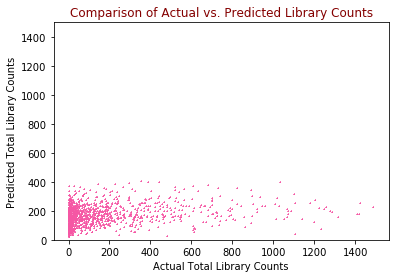

In [60]:
plt.scatter(y_test, rfr_bp2_predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,1500)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount_test.png", dpi=150)

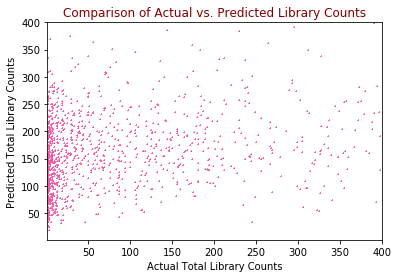

In [61]:
plt.scatter(y_test, rfr_bp2_predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,400)
plt.xlim(1,400)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount_detail_test.png", dpi=150)

In [100]:
features = X2_train.columns

In [101]:
feature_imp_df = pd.DataFrame([features, rfr_best_params_2.feature_importances_]).transpose()
feature_imp_df.sort_values(by=1, ascending=False).head(20)

,0,1
0,age_in_2017,0.151847
4,title_length,0.102907
759,Tattoo,0.0602155
808,The,0.0540474
3,number_of_words,0.0519837
1,sentiment_polarity,0.0395271
2,sentiment_subjectivity,0.0392693
56,American,0.0294069
210,Culture,0.026362
64,Ancient,0.0198196


### fit the model to the entire dataset

In [40]:
rfr_final = RandomForestRegressor(max_depth=20, max_features=0.3, min_samples_leaf=5, n_estimators=100)
rfr_final.fit(X2, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [41]:
features_final = X2.columns

In [105]:
feature_imp_final = pd.DataFrame([features_final, rfr_final.feature_importances_]).transpose()
feature_imp_final.sort_values(by=1, ascending=False).head(20)

,0,1
0,age_in_2017,0.135465
4,title_length,0.103056
759,Tattoo,0.0606295
808,The,0.0468507
3,number_of_words,0.0446956
56,American,0.0279653
2,sentiment_subjectivity,0.0278731
210,Culture,0.0277275
1,sentiment_polarity,0.0275087
786,Tattoos,0.0165467


In [42]:
#add scoring on whole model
predictions = rfr_final.predict(X2)

In [45]:
rfr_final.score(X2, y)

0.26069499017390874

In [46]:
explained_variance_score(y, predictions)

0.26070284973951174

In [47]:
mean_absolute_error(y, predictions)

146.40419586424596

In [48]:
mean_squared_error(y, predictions)

47513.056744228146

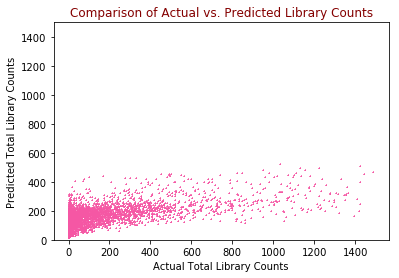

In [49]:
plt.scatter(y, predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,1500)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount.png", dpi=150)

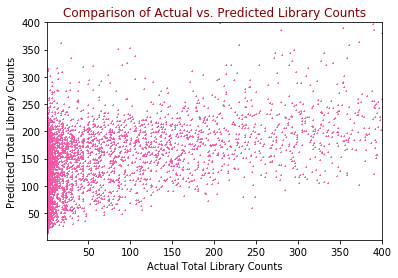

In [50]:
plt.scatter(y, predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,400)
plt.xlim(1,400)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount_detail.png", dpi=150)

In [132]:
rfr_final.predict(pd.read_csv("test_data/test titles/X2_Ancient_Inkc_the_historical_mystery_of_tattoos.csv"))

array([ 157.94453612])

In [133]:
rfr_final.predict(pd.read_csv("test_data/test titles/X2_Ancient_Inkc_the_historical_mystery_of_tattoos_5.csv"))

array([ 157.58342734])

In [134]:
rfr_final.predict(pd.read_csv("test_data/test titles/X2_Ancient_Inkc_the_historical_mystery_of_tattoos_10.csv"))

array([ 153.91729899])

In [135]:
rfr_final.predict(pd.read_csv("test_data/test titles/X2_I_love_cats.csv"))

array([ 94.6088985])

In [136]:
rfr_final.predict(pd.read_csv("test_data/test titles/X2_Tattoos_Rock.csv"))

array([ 77.89129454])

In [137]:
rfr_final.predict(pd.read_csv("test_data/test titles/X2_Tattoos_Rock_2.csv"))

array([ 65.80505465])

In [138]:
rfr_final.predict(pd.read_csv("test_data/test titles/X2_Tattoos_Rock_10.csv"))

array([ 79.50278803])

### try the gradient boosting regressor just for kicks

In [ ]:
gbr = GradientBoostingRegressor()
gbr.fit(X2_train, y_train)

In [ ]:
gbr.score(X2_train, y_train)

In [ ]:
gbr.score(X2_test, y_test)

In [ ]:
gbr_predictions = gbr.predict(X2_test)

In [ ]:
explained_variance_score(gbr_predictions, y_test)

In [ ]:
mean_absolute_error(gbr_predictions, y_test)

In [ ]:
mean_squared_error(gbr_predictions, y_test)

In [ ]:
plt.scatter(y_test, gbr_predictions)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [ ]:
# parameters = {"min_samples_leaf": range(1,20), "max_depth": range(1,50), "max_features": np.arange( 0.0, 1.0+0.0, 0.1 ).tolist(), "n_estimators": range(1,500)}
# rscv = RandomizedSearchCV(gbr, parameters, verbose=10)


In [ ]:
# rscv.fit(X2_train, y_train)

In [ ]:
# #was 0.016660259457341956
# rscv.best_score_

In [ ]:
# #were:
# {'max_depth': 5,
#  'max_features': 0.1,
#  'min_samples_leaf': 7,
#  'n_estimators': 96}
# rscv.best_params_

In [ ]:
#NOTE: As with above need to redo this RandomizedSearch!!!!!
gbr_be = GradientBoostingRegressor(max_depth=5, max_features=0.10, min_samples_leaf=7, n_estimators=100)
gbr_be.fit(X2_train, y_train)

In [ ]:
gbr_be.score(X2_test, y_test)

In [ ]:
gbr_be_predictions = gbr_be.predict(X2_test)

In [ ]:
explained_variance_score(y_test, gbr_be_predictions)

In [ ]:
mean_absolute_error(y_test, gbr_be_predictions)

In [ ]:
plt.scatter(y_test, gbr_be_predictions, marker="+", s=1)
plt.ylim(1,1400)
plt.figure(figsize=(20,10), dpi=150)

### Note: here I re-run the model with max_depth increased because the above seemed like it was plateau-ing, ideally I'd like to do a GridSearch now using the below as a stepping off point for a narrow range of values than what was in the RandomizedSearch

In [ ]:
# #re-run with max_depth adjusted:
gbr_2 = GradientBoostingRegressor(max_depth=10, max_features=0.10, min_samples_leaf=10, n_estimators=100)
gbr_2.fit(X2_train, y_train)

In [ ]:
gbr_2_predictions = gbr_2.predict(X2_test)

In [ ]:
gbr_2.score(X2_test, y_test)

In [ ]:
mean_absolute_error(y_test, gbr_2_predictions)

In [ ]:
explained_variance_score(y_test, gbr_2_predictions)

In [ ]:
plt.scatter(y_test, gbr_2_predictions, marker="+", s=1)
plt.ylim(0,1400)